In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
!pip install numpy matplotlib tensorflow keras

In [ ]:
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from IPython.display import Image, display
from tensorflow.keras.models import Model, Sequential

In [ ]:
(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1.  # Normalize [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)
y_train_ohe = to_categorical(y_train, num_classes=10)

In [ ]:
from keras.utils import to_categorical
y_train_ohe = to_categorical(y_train, num_classes=10)


In [ ]:
print(f"Data shape: {X_train.shape}")

Data shape: (60000, 28, 28, 1)


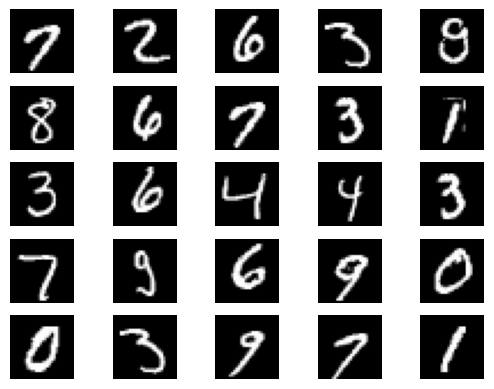

In [ ]:
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis(False)
  plt.imshow(X_train[random.randint(0,99)], cmap='gray')

plt.show()

In [ ]:
def generator_model(latent_dim, num_classes, image_shape):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    x = concatenate([noise_input, label_input])

    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim + num_classes, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(np.prod(image_shape), activation='tanh'))
    model.add(Reshape(image_shape))

    generated_image = model(x)
    return Model([noise_input, label_input], generated_image)

In [ ]:
def discriminator_model(image_shape, num_classes):
    image_input = Input(shape=image_shape)
    label_input = Input(shape=(num_classes,))

    flat_image = Flatten()(image_input)
    x = concatenate([flat_image, label_input])

    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(image_shape) + num_classes, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    validity = model(x)
    return Model([image_input, label_input], validity)

In [ ]:
def CGAN_models(latent_dim, image_shape, num_classes):
    generator = generator_model(latent_dim, num_classes, image_shape)
    discriminator = discriminator_model(image_shape, num_classes)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    generated_image = generator([noise_input, label_input])

    discriminator.trainable = False
    validity = discriminator([generated_image, label_input])

    gan = Model([noise_input, label_input], validity)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return generator, discriminator, gan


In [ ]:
def plot_generated(generator, latent_space, num_classes, epoch):
    rows, cols = 5, 5
    noise = np.random.normal(0, 1, (rows * cols, latent_space))
    labels = to_categorical(np.arange(0, rows * cols) % num_classes, num_classes=num_classes)
    gen_imgs = generator.predict([noise, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(rows, cols, figsize=(6,6))
    count = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(np.argmax(labels[count]))
            count += 1
    fig.tight_layout()
    fig.savefig(f"results/{epoch}.png")
    plt.close()


In [ ]:
def train_model(generator, discriminator, gan, X_train, y_train, latent_dim, num_classes, epochs=1000):
    batch_size = 128
    sample_interval = 100
    print_interval = 25
    generator_loss, discriminator_loss = [], []

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        images_real = X_train[idx]
        labels_real = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        labels_fake = y_train[np.random.randint(0, y_train.shape[0], batch_size)]
        images_fake = generator.predict([noise, labels_fake])

        X = np.concatenate([images_real, images_fake])
        y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels_combined = np.concatenate([labels_real, labels_fake])

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch([X, labels_combined], y)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = y_train[np.random.randint(0, y_train.shape[0], batch_size)]
        y_gan = np.ones((batch_size, 1))
        discriminator.trainable = False
        g_loss = gan.train_on_batch([noise, sampled_labels], y_gan)

        if epoch % print_interval == 0:
            print(f"Epoch: {epoch} | D Loss: {d_loss[0]:.4f} | G Loss: {g_loss:.4f}")
            discriminator_loss.append(d_loss[0])
            generator_loss.append(g_loss)

        if epoch % sample_interval == 0:
            generate_and_save_images(generator, latent_dim, y_train, epoch)

    plot_loss(discriminator_loss, generator_loss)


In [ ]:
def generate_and_save_images(generator, latent_dim, y_data, epoch):
    rows, cols = 5, 5
    noise = np.random.normal(0, 1, (rows * cols, latent_dim))
    sampled_labels = to_categorical(np.array([i for i in range(cols)] * rows), num_classes=10)
    generated_images = generator.predict([noise, sampled_labels])
    generated_images = 0.5 * generated_images + 0.5

    fig, axs = plt.subplots(rows, cols, figsize=(5,5))
    count = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1
    if not os.path.exists('results'):
        os.makedirs('results')
    fig.savefig(f"results/{epoch}.png")
    plt.close()

def plot_loss(d_loss, g_loss):
    plt.figure()
    plt.plot(d_loss, label='Discriminator Loss')
    plt.plot(g_loss, label='Generator Loss')
    plt.xlabel("Print Interval Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from keras.layers import concatenate


In [ ]:
latent_dim = 128
num_classes = 10
image_shape = (28, 28, 1)

generator, discriminator, gan = CGAN_models(latent_dim, image_shape, num_classes)

train_model(generator, discriminator, gan, X_train, y_train_ohe, latent_dim, num_classes, epochs=20000)

generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")
gan.save("gan_model.h5")
print("✅ Modeller kaydedildi.")


In [ ]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt

num_samples = 10
latent_dim = 128

noise = np.random.normal(0, 1, (num_samples, latent_dim))
labels = to_categorical([5]*num_samples, num_classes=10)

generated_images = generator.predict([noise, labels])

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()
